In [1]:
# coding: utf-8
%pylab inline
import random
import math
import time 
import itertools
from math import log as ln
import pandas as pd
import numpy as np
from scipy import spatial
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from gurobipy import *

Populating the interactive namespace from numpy and matplotlib


# Create a simulated universe with different selection intervals for catalogs

In [2]:
num_catalog = 30

In [3]:
def mock(num=10, size=10, seed=None):
    "return dataframe of simulated objects"
    if seed is not None: 
        np.random.seed(seed)
    obj = np.random.random(size=(num,3)) 
    obj[:,0:2] *= size;  obj[:,1] -= size/2 #The location is scaled to simulate objects on a 10x10 grid. 
    #objid = np.arange(obj.shape[0]) # object id
    df = pd.DataFrame(obj,columns=['x','y','u'])
    return df

In [4]:
def cat(mdf, sigma, select):
    "return simulated catalog and selection"
    det = mdf.values[:,:2] + sigma * np.random.randn(mdf.shape[0],2)
    df = pd.DataFrame(det,columns=['x','y'])
    a, b = select
    sel = np.logical_and(mdf.u>=a, mdf.u<b)
    df['selected'] = np.array(sel, dtype=np.bool)
    return df

In [5]:
#sigma_rad = sigma/3600 * pi/180
np.random.seed(20)
num=100
size=30
Qmat=np.empty((1,2))
m = mock(num=num,size=size, seed = 20)
# generate 3 catalogs with sigma=0.1" and different selection intevals
sigma = 0.04
c = [cat(m,sigma,iv) for iv in [(0, 1)]*num_catalog] #List of catalogs with coordinates and conditions

cmat = []

for i in range(num_catalog):
    cmat.append(c[i][c[i].selected][['x','y']].values)

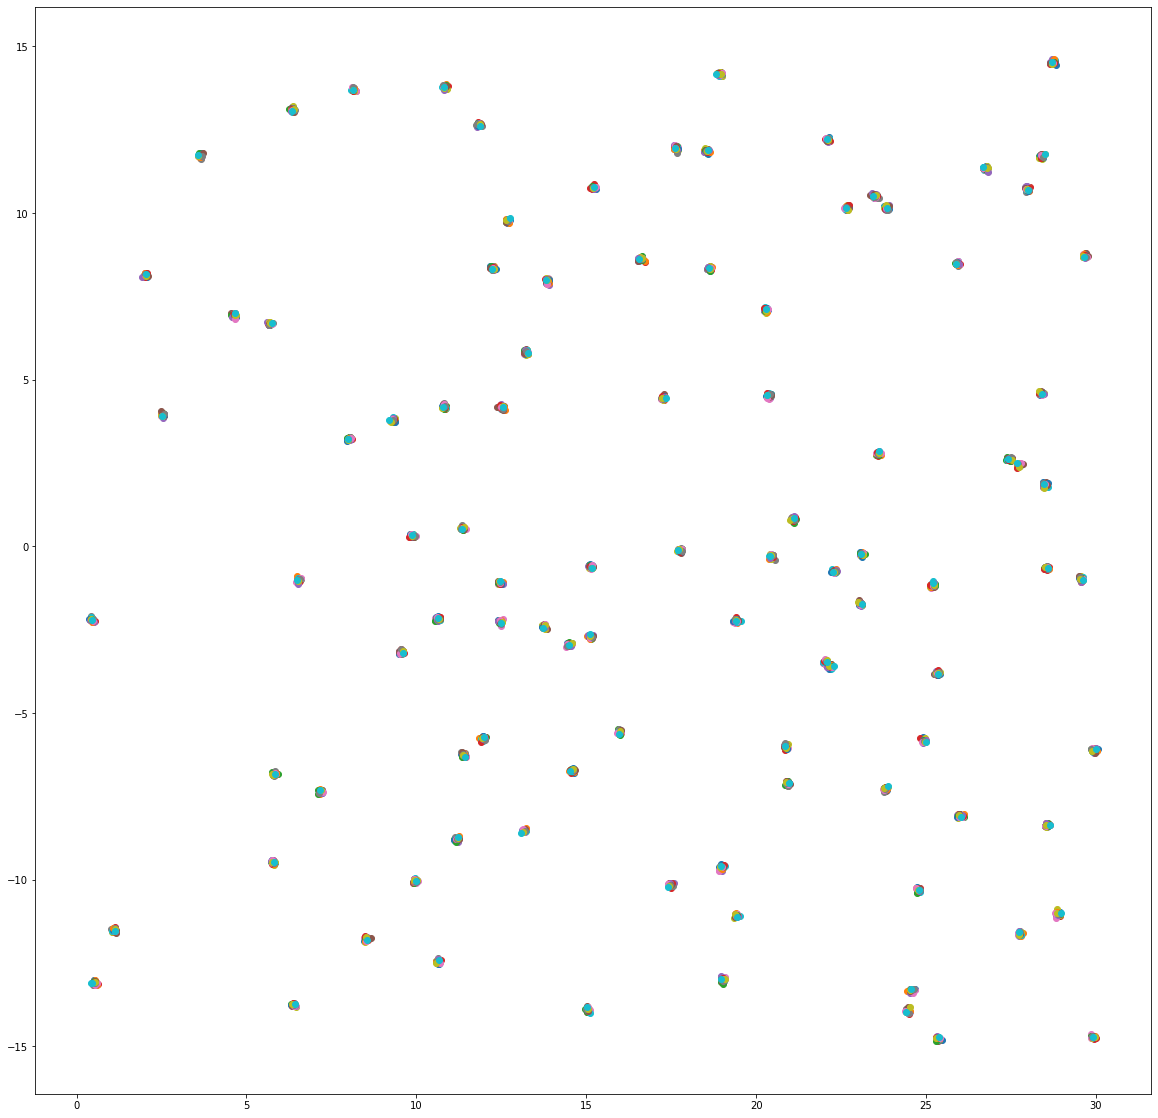

In [6]:
fig = plt.figure(figsize=(20,20))
for i in range(num_catalog):
    x, y = cmat[i].T
    plt.scatter(x,y)
plt.show()

# Nway matching procedure

### DBSCAN Algorithm for Clustering 

Number of clusters: 98


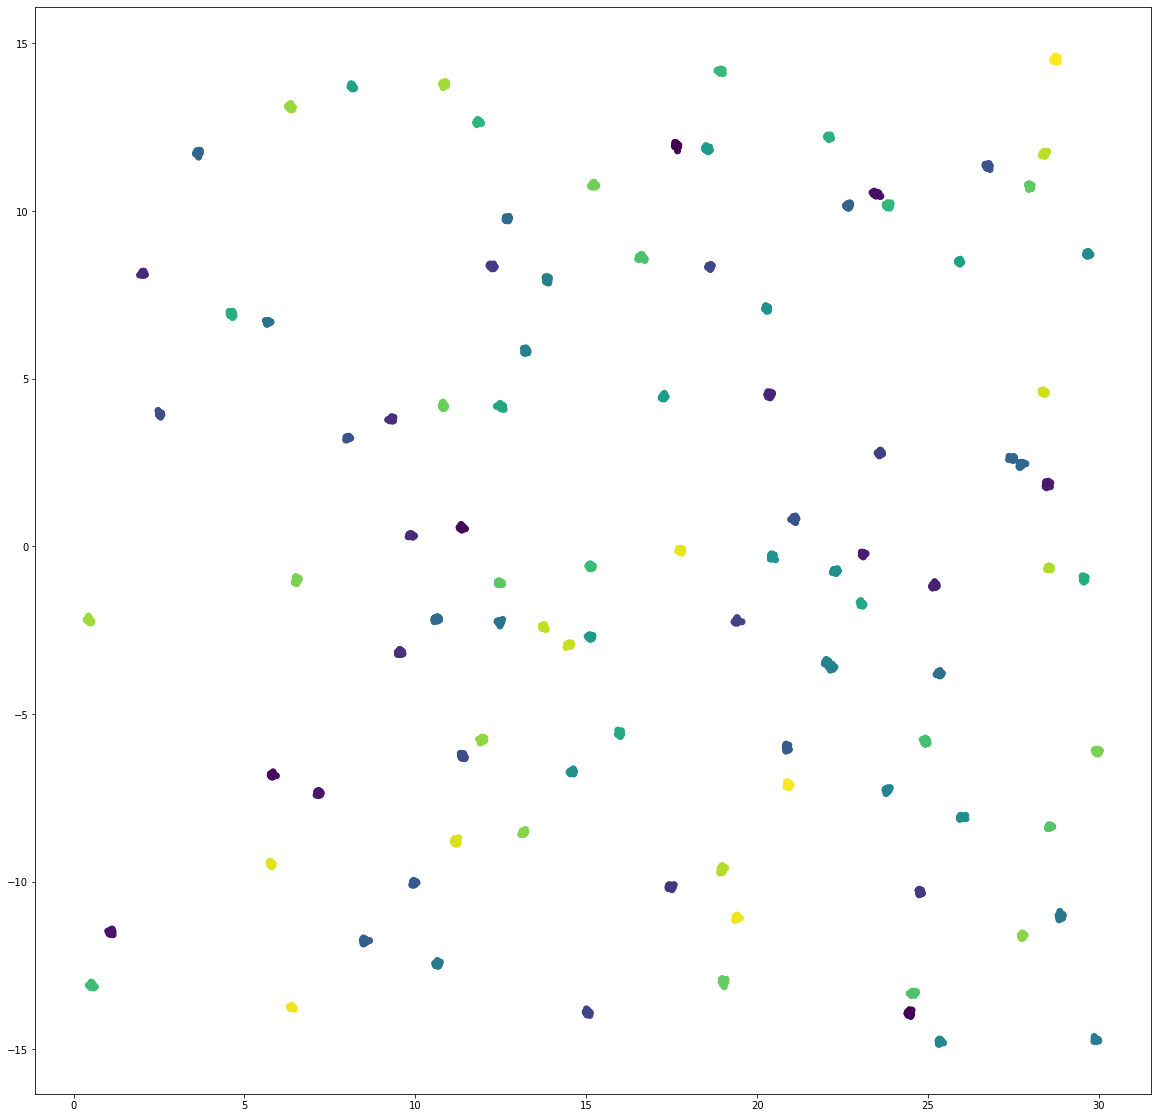

In [7]:
label = []
X = []
for i in range(num_catalog):
    label += [i]*len(cmat[i])
    first_coord, second_coord = cmat[i].T
    X += [(i, j) for i, j in zip(first_coord, second_coord)]
label = np.array(label)
X = np.array(X)
result = DBSCAN(eps=5*sigma, min_samples=2).fit(X)
y_pred = DBSCAN(eps=5*sigma, min_samples=2).fit_predict(X)
fig = plt.figure(figsize=(20,20))
plt.scatter(X[:,0], X[:,1], c=y_pred)
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [8]:
def get_candidate_list(clustering_result, catalog_label, clustering_label, cmat):
    """
    Get all the (catalog_id, source_id) pairs
    """
    candidate_dict = {}
    list_of_label = catalog_label[np.where(clustering_result.labels_==clustering_label)] #The catalog id of all sources found in the island
    for j in np.unique(list_of_label):
        list_of_indices = []
        for k in range(sum(list_of_label==j)):
            list_of_indices.append((j,(np.where(cmat[j]==clustering_result.components_[np.where(clustering_result.labels_==clustering_label)][list_of_label==j][k])[0][0])))
        candidate_dict[j] = list_of_indices # catalog id: (catalog id, source id)
        
    # Get all the (catalog_id, source_id) pairs
    catalog_list = []
    for key in candidate_dict.keys():
        list_of_value = candidate_dict[key]
        for pair in list_of_value:
            catalog_list.append(pair)
    return (catalog_list, len(np.unique(list_of_label)))

In [9]:
def get_distance(list_of_indexes, cmat):
    '''
    Given 2 pairs of (catalog_index, source_index), return the square distance between them
    '''
    coord_list = []
    for i in range(2):
        coord_list+=[cmat[list_of_indexes[i][0]][list_of_indexes[i][1]]]
    
    array_matrix = np.array(coord_list)
    return(np.linalg.norm(array_matrix[1]-array_matrix[0])**2)


In [10]:
def sum_of_distance(list_of_objects):
    '''
    Given n pairs of (catalog_index, source_index), return the sum of all pairwise square distance.
    '''
    num_of_objects = len(list_of_objects)
    coord_list = []
    for i in range(num_of_objects):
        coord_list+=[cmat[list_of_objects[i][0]][list_of_objects[i][1]]]
    array_matrix = np.array(coord_list) 
    pairwise_dist = spatial.distance.pdist(np.array(array_matrix))**2
    sum_of_square_dist = sum(pairwise_dist)
    return sum_of_square_dist

In [11]:
def Bayes_factor(list_of_objects):
    '''
    Compute -ln Bo
    '''
    num_of_objects = len(list_of_objects)
    return(ln(num_of_objects) - (num_of_objects - 1) * ln(2) + (2*num_of_objects - 2)*ln(sigma * np.pi/180/3600) + sum_of_distance(list_of_objects)/(4*num_of_objects*sigma**2)) 

In [12]:
def compute_distance_dictionary(list_of_indexes):
    distance_dict = {}
    for current_pair_index in range(len(list_of_indexes)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indexes)):
            if list_of_indexes[next_pair_index][0]!= list_of_indexes[current_pair_index][0]:
                distance_dict[(list_of_indexes[current_pair_index],list_of_indexes[next_pair_index])] = get_distance([list_of_indexes[current_pair_index],list_of_indexes[next_pair_index]],cmat)
    return distance_dict

In [16]:
#Modify Gurobi procesure
def mycallback(model, where):
    start_time = [0]
    if where == GRB.Callback.POLLING:
        # Ignore polling callback
        pass
    elif where == GRB.Callback.PRESOLVE:
        # Presolve callback
        cdels = model.cbGet(GRB.Callback.PRE_COLDEL) #number of cols removed by presolve to this point
        rdels = model.cbGet(GRB.Callback.PRE_ROWDEL) #number of rows removed by presolve to this point
    elif where == GRB.Callback.SIMPLEX: #Currently in simplex
        # Simplex callback
        itcnt = model.cbGet(GRB.Callback.SPX_ITRCNT) #Current simplex iteration count
        #if itcnt - model._lastiter >= 100:
        model._lastiter = itcnt
        obj = model.cbGet(GRB.Callback.SPX_OBJVAL) # Current simplex objective value
        ispert = model.cbGet(GRB.Callback.SPX_ISPERT) 
        pinf = model.cbGet(GRB.Callback.SPX_PRIMINF) # Current primal infeasibility
        dinf = model.cbGet(GRB.Callback.SPX_DUALINF) # Current dual infeasibility
        if ispert == 0:
            ch = ' '
        elif ispert == 1:
            ch = 'S'
        else:
            ch = 'P'
        print('**** SIMPLEX %d %g%s %g %g ****' % (int(itcnt), obj, ch, pinf, dinf))
    elif where == GRB.Callback.MIP: #Currently in MIP
        # General MIP callback
        nodecnt = model.cbGet(GRB.Callback.MIP_NODCNT) #Current explored node count
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST) #Current best objective
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND) #Current best objective bound
        solcnt = model.cbGet(GRB.Callback.MIP_SOLCNT) #Current count of feasible solutions found
        #if nodecnt - model._lastnode >= 100:
        model._lastnode = nodecnt
        actnodes = model.cbGet(GRB.Callback.MIP_NODLFT) #Current unexplored node count
        itcnt = model.cbGet(GRB.Callback.MIP_ITRCNT) #Current simplex iteration count
        cutcnt = model.cbGet(GRB.Callback.MIP_CUTCNT) #Current count of cutting planes applied
        print('Explored Node count %d, Unexplored Node count %d, iteration count %d, Best objective %g, Best objective bound %g, Feasible soln count %d, Cut count %d' % (nodecnt, actnodes,
              itcnt, objbst, objbnd, solcnt, cutcnt))
        if model.cbGet(GRB.Callback.RUNTIME) - start_time[-1] > 2700: #Set a time limit of 45 minutes between feasible solutions
            print('Stop early - Time limit achieved')
            model.terminate()
    elif where == GRB.Callback.MIPSOL: #Found a new MIP incumbent
        # MIP solution callback
        start_time.append(model.cbGet(GRB.Callback.RUNTIME)) 
        nodecnt = model.cbGet(GRB.Callback.MIPSOL_NODCNT) #Current explored node count
        obj = model.cbGet(GRB.Callback.MIPSOL_OBJ) #Objective value for new solution
        objbst = model.cbGet(GRB.Callback.MIPSOL_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIPSOL_OBJBND)
        solcnt = model.cbGet(GRB.Callback.MIPSOL_SOLCNT) #Curent count of feasible solutions found
        best_gap = abs(100*(objbnd - objbst)/objbst)
        current_gap = abs(100*(objbnd - obj)/obj) #Gap of the new solution found
        x_MIP = model.cbGetSolution(model._vars)
        x_MIP = np.array(x_MIP)
        index_list = np.where(x_MIP > 0.1)
        res_list = [model._vars[i] for i in index_list[0]]
        nonzero_x = []
        for solution in res_list:
            if solution.Varname[1:4] == "'x'":
                nonzero_x.append(solution.VarName)
        print('**** New solution # %d, Obj %g, Current Gap %g%%, Best Obj %g, Best Gap %g%%, Elapsed time %g,'
               % (solcnt, obj, current_gap, objbst, best_gap, model.cbGet(GRB.Callback.RUNTIME)))
        for i in range(len(nonzero_x)):
            print('\n x = %s' %nonzero_x[i])
        model._logfile.write('\n**** New solution # %d, Obj %g, Current Gap %g%%, Best Obj %g, Best Gap %g%%, Elapsed time %g,'
               % (solcnt, obj, current_gap, objbst, best_gap, model.cbGet(GRB.Callback.RUNTIME)))
        for i in range(len(nonzero_x)):
            model._logfile.write('\n x = %s' %nonzero_x[i])
        print("Start time:", start_time)

    elif where == GRB.Callback.MIPNODE: #Currently exploring a MIP node
        # MIP node callback
        print('**** New node ****')
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            x = model.cbGetNodeRel(model._vars) #Values from the node relaxation solution at the current node
            model.cbSetSolution(model.getVars(), x)
    elif where == GRB.Callback.BARRIER:
        # Barrier callback
        itcnt = model.cbGet(GRB.Callback.BARRIER_ITRCNT)
        primobj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        dualobj = model.cbGet(GRB.Callback.BARRIER_DUALOBJ)
        priminf = model.cbGet(GRB.Callback.BARRIER_PRIMINF)
        dualinf = model.cbGet(GRB.Callback.BARRIER_DUALINF)
        cmpl = model.cbGet(GRB.Callback.BARRIER_COMPL)
        print('%d %g %g %g %g %g' % (itcnt, primobj, dualobj,
              priminf, dualinf, cmpl))
    elif where == GRB.Callback.MESSAGE:
        # Message callback
        msg = model.cbGet(GRB.Callback.MSG_STRING)
        model._logfile.write(msg)

### DIRILP Special Case - Constant sigma

In [20]:
#Conduct the crossmatch on 1 of the island:
desired_label = 0

catalog_list, catalog_total = get_candidate_list(result, label, desired_label, cmat)
detection_total = len(catalog_list) #Total number of sources across different catalogs

# DIRLIP ALGORITHM

mo = Model("likelihood")

M = np.ceil(sum_of_distance(catalog_list)/(4*sigma**2))
var_x_dict = {}
var_y_dict = {}
var_z_dict = {}
var_w_dict = {}
t_list = []
p_list = []
a_list = [0]

########################### SET VARIABLES ###########################

# Compute a_list
for catalog_index in range(catalog_total - 1):
    a_list.append(ln(catalog_index + 2) - ln(catalog_index + 1))

# Variables for x
for subset_index in range(detection_total):
    for catalog_source_pair in catalog_list:
        var_x_dict[('x', subset_index, catalog_source_pair)] = mo.addVar(vtype=GRB.BINARY, name=str(('x', subset_index, catalog_source_pair)))

# Variables for y
for subset_index in range(detection_total):
    for product_of_catalog_source_pairs in list(itertools.combinations(catalog_list, r = 2)):
        if product_of_catalog_source_pairs[0][0] != product_of_catalog_source_pairs[1][0]:
            var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] = mo.addVar(vtype=GRB.BINARY, name=str(('y', subset_index, product_of_catalog_source_pairs[0],product_of_catalog_source_pairs[1])))

# Variables for z
for subset_index in range(detection_total):
    for catalog_index in range(catalog_total + 1):
        var_z_dict[('z', subset_index, catalog_index)] = mo.addVar(vtype=GRB.BINARY, name=str(('z', subset_index, catalog_index)))

# Variables for t
for subset_index in range(detection_total):  
    t_list.append(mo.addVar(lb = 0, vtype=GRB.CONTINUOUS, name=str(('t', subset_index))))

# Variables for p
for subset_index in range(detection_total):  
    p_list.append(mo.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS, name=str(('p', subset_index))))

# Variables for w
for subset_index in range(detection_total):
    for catalog_index in range(catalog_total):
        var_w_dict[('w', subset_index, catalog_index)] = mo.addVar(vtype=GRB.BINARY, name=str(('w', subset_index, catalog_index)))

########################### SET OBJECTIVES ###########################

# Set objective
mo.setObjective(quicksum(p_list[subset_index] + quicksum(var_w_dict[('w', subset_index, catalog_index)]*a_list[catalog_index] for catalog_index in range(catalog_total)) + t_list[subset_index] for subset_index in range(detection_total)), GRB.MINIMIZE)

########################### SET CONSTRAINTS ###########################

# All detections (i,c) needs to belong to some subset (S_j)
#Equation A3
for catalog_source_pair in catalog_list:    
    x_constraint = []
    for variable in var_x_dict.keys():
        if variable[-1] == catalog_source_pair:
            x_constraint.append(var_x_dict[variable])
    mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.EQUAL, rhs = 1)

# Every subset takes no more than 1 detection from each catalog
#Equation A4
for subset_index in range(detection_total):
    for catalog_index in range(catalog_total):
        x_constraint = []
        for variable in var_x_dict.keys():
            if (variable[1] == subset_index) & (variable[-1][0] == catalog_index):
                x_constraint.append(var_x_dict[variable])
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.LESS_EQUAL, rhs = 1)

# Definition of variables y
# Equation A5 - A7
for subset_index in range(detection_total):
    for product_of_catalog_source_pairs in list(itertools.combinations(catalog_list, r = 2)):
        if product_of_catalog_source_pairs[0][0] != product_of_catalog_source_pairs[1][0]:
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] >= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[0])] + var_x_dict[('x', subset_index, product_of_catalog_source_pairs[1])] - 1)
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] <= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[0])])
            mo.addConstr(var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])] <= var_x_dict[('x', subset_index, product_of_catalog_source_pairs[1])])

# The cardinality of any subset from a partition P is from 0 to K
# Equation A8
for subset_index in range(detection_total):
    z_constraint = []
    for catalog_index in range(catalog_total + 1):
        z_constraint.append(var_z_dict[('z', subset_index, catalog_index)])
    mo.addConstr(lhs = quicksum(variable for variable in z_constraint), sense=GRB.EQUAL, rhs = 1)

# Definition of variables w
# Equation A9
for subset_index in range(detection_total):
    w_constraint = []
    x_constraint = []
    for catalog_index in range(catalog_total):
        w_constraint.append(var_w_dict[('w', subset_index, catalog_index)])
    for catalog_source_pair in catalog_list:    
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)])
    mo.addConstr(lhs = quicksum(variable for variable in w_constraint), sense=GRB.EQUAL, rhs = quicksum(variable for variable in x_constraint))
    for w_index in range(len(w_constraint) - 1):
        mo.addConstr(w_constraint[w_index] >= w_constraint[w_index + 1])

# Definition of variables t
# Equation A10
for subset_index in range(detection_total):
    for catalog_index in range(1, catalog_total + 1):
        mo.addConstr(lhs = t_list[subset_index], sense=GRB.GREATER_EQUAL, 
                     rhs = -M * (1 - var_z_dict[('z', subset_index, catalog_index)]) + quicksum(1/(4*catalog_index * sigma**2)*var_y_dict[('y', subset_index, product_of_catalog_source_pairs[0], product_of_catalog_source_pairs[1])]*get_distance(product_of_catalog_source_pairs, cmat) for product_of_catalog_source_pairs in list(itertools.combinations(catalog_list, r = 2)) if product_of_catalog_source_pairs[0][0] != product_of_catalog_source_pairs[1][0]))

# Definition of variables p
# Equation A13
for subset_index in range(detection_total):
    mo.addConstr(lhs = p_list[subset_index], sense=GRB.GREATER_EQUAL, 
                     rhs = ln(2*1/(sigma*np.pi/180/3600)**2)*(1 - quicksum(var_w_dict[('w', subset_index, catalog_index)] for catalog_index in range(catalog_total)) - ln(2*1/(sigma*np.pi/180/3600)**2)*var_z_dict[('z', subset_index, 0)]))

# Definition of variables z
# Equation A11 - A12
for subset_index in range(detection_total):
    x_constraint = []
    for catalog_source_pair in catalog_list:
        x_constraint.append(var_x_dict[('x', subset_index, catalog_source_pair)])
    for catalog_index in range(catalog_total + 1):
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.LESS_EQUAL,
                     rhs = catalog_index * var_z_dict[('z', subset_index, catalog_index)] + catalog_total * (1 - var_z_dict[('z', subset_index, catalog_index)]))
        mo.addConstr(lhs = quicksum(variable for variable in x_constraint), sense=GRB.GREATER_EQUAL,
                     rhs = catalog_index * var_z_dict[('z', subset_index, catalog_index)])

# Heuristic constraints:
distance_dict = compute_distance_dictionary(catalog_list)
dist_constraint_var=[]
for pair,distance in distance_dict.items():
    for j in range(detection_total):
        if distance > 3*sigma:
            dist_constraint_var.append(var_y_dict[tuple(['y']+[j]+list(pair))])
for variable in dist_constraint_var:
    variable.ub = 0 #If 2 sources are 3 sigma away from each other, they do not correspond to the same object
    
########################### OPTIMIZATION ###########################
# Open log file
#mo.reset()
mo.update()

logfile = open('DirILP'+str(num_catalog)+'_catalogs.log', 'w')
logfile.write('Theoretical optimal solution: %s' % (Bayes_factor(catalog_list)))
# Pass data into my callback function

#mo._lastiter = -GRB.INFINITY
#mo._lastnode = -GRB.INFINITY
mo._logfile = logfile
mo._vars = mo.getVars()

# Solve model

#mo.Params.MIPGap = 0.01
mo.optimize(mycallback)

# Close log file

logfile.close()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 43800 rows, 15840 columns and 549480 nonzeros
Model fingerprint: 0xd81fb5a2
Variable types: 60 continuous, 15780 integer (15780 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
**** New solution # 0, Obj -10972.8, Current Gap 9.11345e+97%, Best Obj -10972.8, Best Gap 9.11345e+97%, Elapsed time 0.0862782,

 x = ('x', 0, (13, 0))

 x = ('x', 0, (25, 0))

 x = ('x', 1, (4, 0))

 x = ('x', 1, (7, 0))

 x = ('x', 2, (1, 0))

 x = ('x', 2, (19, 0))

 x = ('x', 5, (10, 0))

 x = ('x', 6, (23, 0))

 x = ('x', 7, (18, 0))

 x = ('x', 7, (20, 0))

 x = ('x', 9, (2, 0))

 x = ('x', 9, (27, 0))

 x = ('x', 10, (16, 0))

 x = ('x', 11, (9, 0))

 x = ('x', 11, (29, 0))

 x = ('x', 12, (12, 0))

 x = ('x', 12, (21, 0))

 x = ('x', 13, (26, 0))

 x = ('x', 14, (17, 0))

 x = ('x', 15, (6, 0))

 x = ('x', 15

In [21]:
#Check the crossmatch between sources
for i in mo.getVars():
    if i.x > 0.5:
        print(i)

<gurobi.Var ('x', 28, (0, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (1, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (2, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (3, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (4, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (5, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (6, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (7, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (8, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (9, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (10, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (11, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (12, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (13, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (14, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (15, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (16, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (17, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (18, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (19, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (20, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (21, 0)) (value 1.0)>
<gurobi.Var ('x', 28, (22, 0)) (value 1.0)